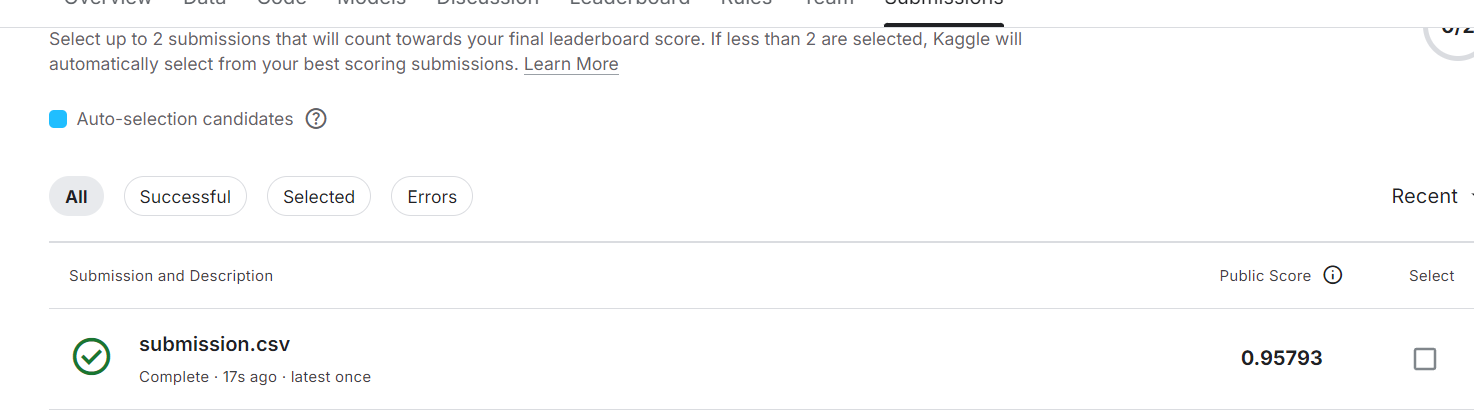

IF YOU LIKE THE NOTEBOOK , PLEASE DO UPVOTE IT :))))!!

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [ ]:
loan_train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')

In [ ]:
loan_train.head()

In [ ]:
loan_train

In [ ]:
print("Rows: ", len(loan_train))
print("Columns: ", len(loan_train.columns))
print("Shape : ", loan_train.shape)
loan_train.columns

In [ ]:
loan_train.describe(exclude=[np.number])

In [ ]:
loan_train.describe().transpose()

In [ ]:
loan_train.info()

In [ ]:
loan_train.isnull().sum()

In [ ]:
loan_train['loan_status'].value_counts()


In [ ]:
msno.matrix(loan_train )

In [ ]:
loan_train['loan_status'].value_counts(normalize=True).sort_index()

In [ ]:
loan_train

In [ ]:
loan_test

In [ ]:
loan_train.plot(figsize=(18, 8))

plt.show()

In [ ]:
print(loan_train.dtypes)


In [ ]:
loan_train_numeric = loan_train.select_dtypes(include=[np.number])


One hot encoding

In [ ]:
loan_train_encoded = pd.get_dummies(loan_train, drop_first=True)


In [ ]:
correlation_matrix = loan_train_numeric.corr()
# or if you used one-hot encoding
# correlation_matrix = loan_train_encoded.corr()


In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.1f', linewidths=.1)
plt.show()


In [ ]:
X = loan_train.drop(columns = ['loan_status'])
y = loan_train['loan_status'].values

In [ ]:
categorical_columns = loan_train.select_dtypes(exclude=['number']).columns.tolist()
print(categorical_columns)

**XGBoostModel**

In [ ]:
from typing import Dict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

In [ ]:
def return_estimator(params:Dict = {}):
    return Pipeline([
        (
            'preproc', 
            ColumnTransformer(
                transformers = [('ohe', OneHotEncoder(sparse_output=False), categorical_columns)],
                remainder='passthrough',
                sparse_threshold=0
            ).set_output(transform='pandas')
        ),
        ('xgb', XGBClassifier(tree_method='hist', **params))
    ])

In [ ]:
!pip install botorch optuna-integration

In [ ]:
import optuna
print(optuna.__version__)


In [ ]:
from typing import Dict, Union
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna
import joblib
import warnings
from optuna.samplers import TPESampler

The TPE Sampler in Optuna is an implementation of the Tree-structured Parzen Estimator (TPE) algorithm, which is a Bayesian optimization technique designed for hyperparameter tuning. The TPE method is particularly effective for optimizing black-box functions that are expensive to evaluate, such as training machine learning models

In [ ]:
def fit_and_test_model(
    X: pd.DataFrame, y: np.ndarray,
    train_index: np.ndarray, valid_index: np.ndarray,
    params: Dict[str, Union[str, int, float]] = {}
) -> float:
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    model = return_estimator(params)
    
    _ = model.fit(X_train, y_train)
    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_valid_pred)

def optuna_objective(trial: optuna.trial.Trial) -> float:
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1500, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.75, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 12, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 100, log=True),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 1000, log=True)
    }

    cv_auc = [
        fit_and_test_model(X, y, train_index, valid_index, params) \
            for train_index, valid_index in StratifiedKFold(
                n_splits=5, shuffle=True, random_state=0
            ).split(X, y)
    ]
    return np.mean(cv_auc)


with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=optuna.exceptions.ExperimentalWarning)
    warnings.simplefilter(action="ignore", category=FutureWarning)

    study = optuna.create_study(
        direction='maximize', 
        study_name='xgboost',
        sampler=TPESampler(n_startup_trials=10, seed=2)
    )

    # run optuna for a maximum of 120 trials or 1 hr wall clock
    study.optimize(optuna_objective, timeout=3600, n_trials=120)
    
    
# save the runs
_ = joblib.dump(study, 'xgboost_auc.pkl')

In [ ]:
fig = optuna.visualization.plot_optimization_history(study, target_name='CV AUC')

fig.update_layout(
    autosize=True,
    width=800,
    height=600
)
fig.show()

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(
    autosize=True,
    width=800,
    height=400
)
fig.show()

Best hyperparameters

In [ ]:
study.best_params

Finalised model

In [ ]:
model = return_estimator(study.best_params)
_ = model.fit(X, y)

# save model
_ = joblib.dump(model, 'xgboost_loan_approval.pkl')

In [ ]:
SUBMISSION TIME AND PREDICITIONS !!!, YAY , YIPEEE!!

In [ ]:
# Load test dataset if it's in a CSV file
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')


In [ ]:
# Assuming `test` has an 'id' column that contains the actual IDs
# Generate predictions (probabilities) for the loan status
loan_status_predictions = model.predict_proba(test)[:, 1]  # Get probabilities for the positive class

# Create the submission DataFrame using the actual 'id' column
submission = pd.DataFrame({
    'id': test['id'],  # Replace with the actual 'id' column from your test dataset
    'loan_status': loan_status_predictions
})

# Save the submission file
submission.to_csv('submission.csv', index=False)

# Check the submission output
submission.head(5)


In [ ]:
# check submission output
submission.head(5)

In [ ]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Full path of the submission file
submission_file_path = os.path.join(current_directory, 'submission.csv')

print("Submission file path:", submission_file_path)


IF YOU LIKE THE NOTEBOOK , PLEASE DO UPVOTE IT :))))!!

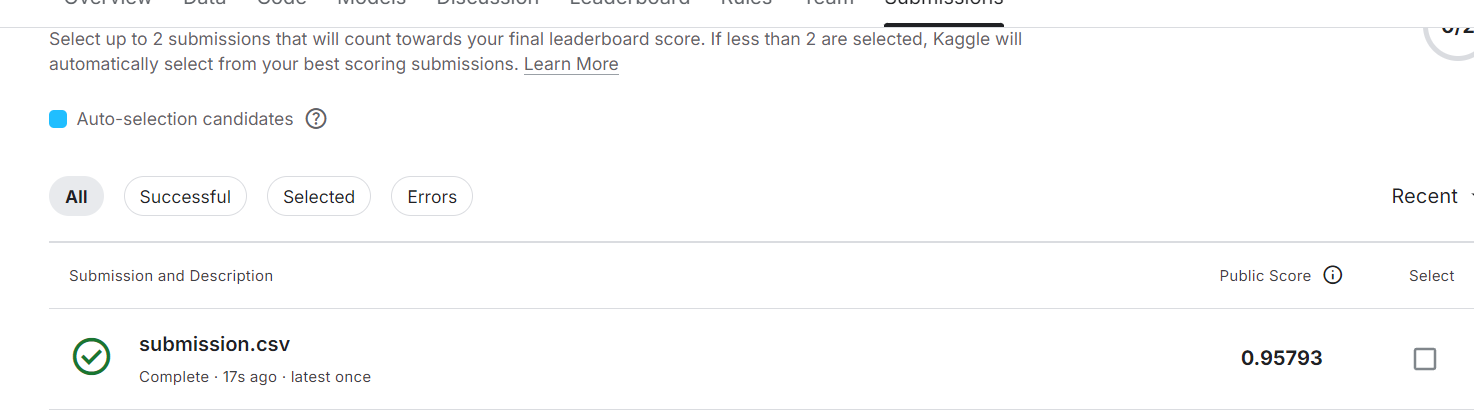
